# **Train advanced GNN model and visualize learned node embeddings.**

**Installations - PyTorch Geometric**

In [ ]:
!pip install torch_geometric

**import PyTorch Geometric and fetch the Cora dataset.**

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

**Define four types of GNN model's class - BaseGNN, GCN, GAT, GraphSAGE**

In [9]:
# Base GNN
class BaseGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = 0.5

    def training_step(self, data):
        self.train()
        out = self(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        return loss

    def get_embeddings(self, data):
        self.eval()
        with torch.no_grad():
            return self.get_intermediate_embeddings(data.x, data.edge_index)

# GCN Implementation
class GCN(BaseGNN):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

    def get_intermediate_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GAT Implementation
class GAT(BaseGNN):
    def __init__(self, num_features, hidden_channels, num_classes, heads=8):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

    def get_intermediate_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Implementation
class GraphSAGE(BaseGNN):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

    def get_intermediate_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

**Trainer class**

In [10]:
# Training and Evaluation Class
class ModelTrainer:
    def __init__(self, model, optimizer, data):
        self.model = model
        self.optimizer = optimizer
        self.data = data
        self.train_accuracies = []
        self.test_accuracies = []
        self.losses = []

    def train_epoch(self):
        self.optimizer.zero_grad()
        loss = self.model.training_step(self.data)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        pred = out.argmax(dim=1)

        train_acc = (pred[self.data.train_mask] == self.data.y[self.data.train_mask]).float().mean()
        test_acc = (pred[self.data.test_mask] == self.data.y[self.data.test_mask]).float().mean()

        return train_acc.item(), test_acc.item()

    def train(self, epochs):
        best_test_acc = 0

        for epoch in range(1, epochs + 1):
            loss = self.train_epoch()
            train_acc, test_acc = self.evaluate()

            self.losses.append(loss)
            self.train_accuracies.append(train_acc)
            self.test_accuracies.append(test_acc)

            if test_acc > best_test_acc:
                best_test_acc = test_acc

            if epoch % 10 == 0:
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
                      f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

        return best_test_acc

**Visualization - training curves + learned node embeddings - function**

In [11]:
# Visualization function
def plot_training_curves(trainer):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curve
    ax1.plot(trainer.losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')

    # Accuracy curves
    ax2.plot(trainer.train_accuracies, label='Train')
    ax2.plot(trainer.test_accuracies, label='Test')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def visualize_embeddings(model, data, title):
    embeddings = model.get_embeddings(data).cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    node_embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1],
                         c=data.y.cpu().numpy(), cmap='tab10')
    plt.colorbar(scatter)
    plt.title(f'Node Embeddings: {title}')
    plt.show()

**Train & compare GCN, GAT, GraphSAGE**

In [12]:
#
models = {
    'GCN': GCN(dataset.num_features, 64, dataset.num_classes),
    'GAT': GAT(dataset.num_features, 64, dataset.num_classes),
    'GraphSAGE': GraphSAGE(dataset.num_features, 64, dataset.num_classes)
}

# store model results
results = {}

#
def train_gnn_model(name):
    model = models[name]
    print(f"\nTraining {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    trainer = ModelTrainer(model, optimizer, data)
    best_acc = trainer.train(200)
    results[name] = {
        'best_acc': best_acc,
        'trainer': trainer,
        'model': model
    }
    plot_training_curves(trainer)
    visualize_embeddings(model, data, name)
    print("Done for {name}")

**Run for GCN**


Training GCN...
Epoch: 010, Loss: 1.8126, Train Acc: 0.9143, Test Acc: 0.6820
Epoch: 020, Loss: 1.0616, Train Acc: 0.9571, Test Acc: 0.7870
Epoch: 030, Loss: 0.3306, Train Acc: 0.9929, Test Acc: 0.8100
Epoch: 040, Loss: 0.1159, Train Acc: 1.0000, Test Acc: 0.7970
Epoch: 050, Loss: 0.0591, Train Acc: 1.0000, Test Acc: 0.7910
Epoch: 060, Loss: 0.0297, Train Acc: 1.0000, Test Acc: 0.7790
Epoch: 070, Loss: 0.0168, Train Acc: 1.0000, Test Acc: 0.7930
Epoch: 080, Loss: 0.0214, Train Acc: 1.0000, Test Acc: 0.7830
Epoch: 090, Loss: 0.0200, Train Acc: 1.0000, Test Acc: 0.7590
Epoch: 100, Loss: 0.0097, Train Acc: 1.0000, Test Acc: 0.7870
Epoch: 110, Loss: 0.0086, Train Acc: 1.0000, Test Acc: 0.7710
Epoch: 120, Loss: 0.0067, Train Acc: 1.0000, Test Acc: 0.7850
Epoch: 130, Loss: 0.0056, Train Acc: 1.0000, Test Acc: 0.7890
Epoch: 140, Loss: 0.0080, Train Acc: 1.0000, Test Acc: 0.7820
Epoch: 150, Loss: 0.0042, Train Acc: 1.0000, Test Acc: 0.7840
Epoch: 160, Loss: 0.0030, Train Acc: 1.0000, Test Acc

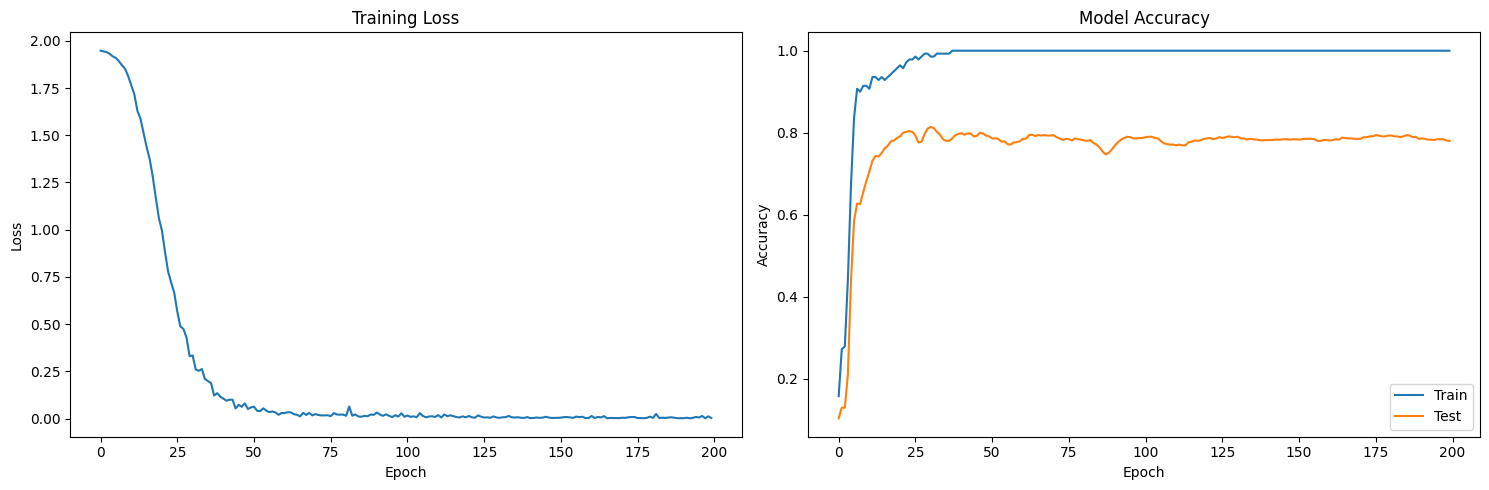

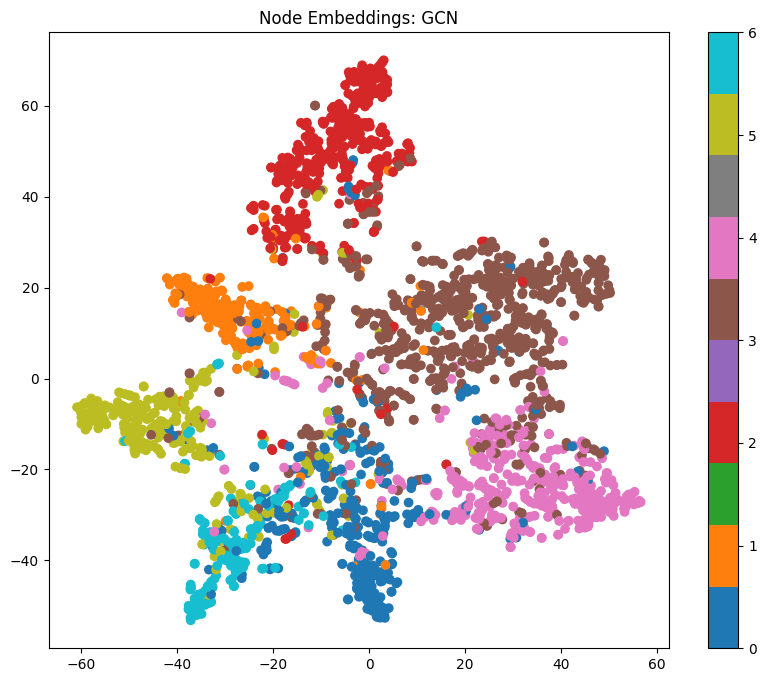

Done for {name}


In [13]:
# GCN
train_gnn_model("GCN")

**Run for GAT**


Training GAT...
Epoch: 010, Loss: 0.5342, Train Acc: 0.9857, Test Acc: 0.7680
Epoch: 020, Loss: 0.0231, Train Acc: 1.0000, Test Acc: 0.7700
Epoch: 030, Loss: 0.0043, Train Acc: 1.0000, Test Acc: 0.7520
Epoch: 040, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.7300
Epoch: 050, Loss: 0.0066, Train Acc: 1.0000, Test Acc: 0.7370
Epoch: 060, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.7490
Epoch: 070, Loss: 0.0128, Train Acc: 1.0000, Test Acc: 0.6590
Epoch: 080, Loss: 0.0249, Train Acc: 1.0000, Test Acc: 0.7420
Epoch: 090, Loss: 0.0030, Train Acc: 1.0000, Test Acc: 0.6170
Epoch: 100, Loss: 0.0006, Train Acc: 1.0000, Test Acc: 0.7120
Epoch: 110, Loss: 0.0008, Train Acc: 1.0000, Test Acc: 0.7580
Epoch: 120, Loss: 0.0003, Train Acc: 1.0000, Test Acc: 0.7530
Epoch: 130, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7150
Epoch: 140, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.7090
Epoch: 150, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.7170
Epoch: 160, Loss: 0.0000, Train Acc: 1.0000, Test Acc

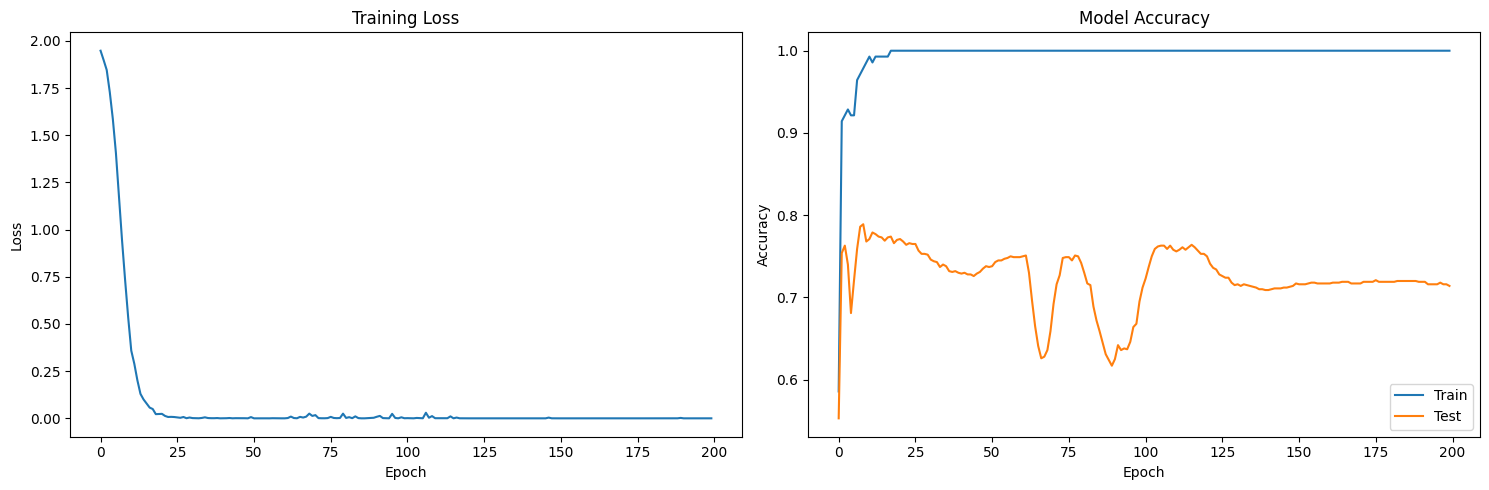

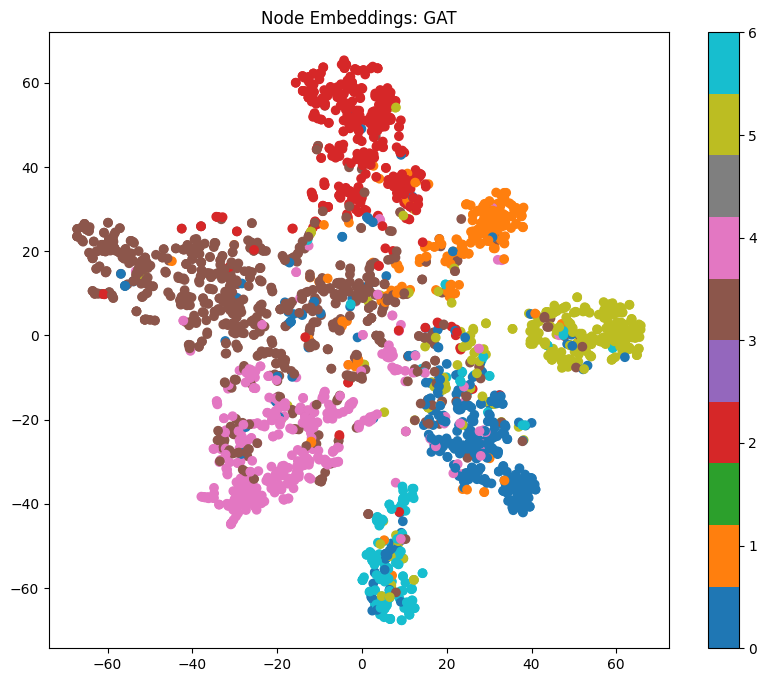

Done for {name}


In [14]:
# GAT
train_gnn_model("GAT")

**Run for GraphSAGE**


Training GraphSAGE...
Epoch: 010, Loss: 1.7333, Train Acc: 0.8714, Test Acc: 0.4470
Epoch: 020, Loss: 0.6789, Train Acc: 1.0000, Test Acc: 0.7570
Epoch: 030, Loss: 0.1732, Train Acc: 1.0000, Test Acc: 0.7820
Epoch: 040, Loss: 0.0360, Train Acc: 1.0000, Test Acc: 0.7790
Epoch: 050, Loss: 0.0141, Train Acc: 1.0000, Test Acc: 0.7760
Epoch: 060, Loss: 0.0105, Train Acc: 1.0000, Test Acc: 0.7660
Epoch: 070, Loss: 0.0106, Train Acc: 1.0000, Test Acc: 0.7630
Epoch: 080, Loss: 0.0192, Train Acc: 1.0000, Test Acc: 0.7770
Epoch: 090, Loss: 0.0092, Train Acc: 1.0000, Test Acc: 0.7740
Epoch: 100, Loss: 0.0040, Train Acc: 1.0000, Test Acc: 0.7550
Epoch: 110, Loss: 0.0075, Train Acc: 1.0000, Test Acc: 0.7650
Epoch: 120, Loss: 0.0032, Train Acc: 1.0000, Test Acc: 0.7770
Epoch: 130, Loss: 0.0019, Train Acc: 1.0000, Test Acc: 0.7690
Epoch: 140, Loss: 0.0015, Train Acc: 1.0000, Test Acc: 0.7510
Epoch: 150, Loss: 0.0232, Train Acc: 1.0000, Test Acc: 0.7380
Epoch: 160, Loss: 0.0039, Train Acc: 1.0000, Te

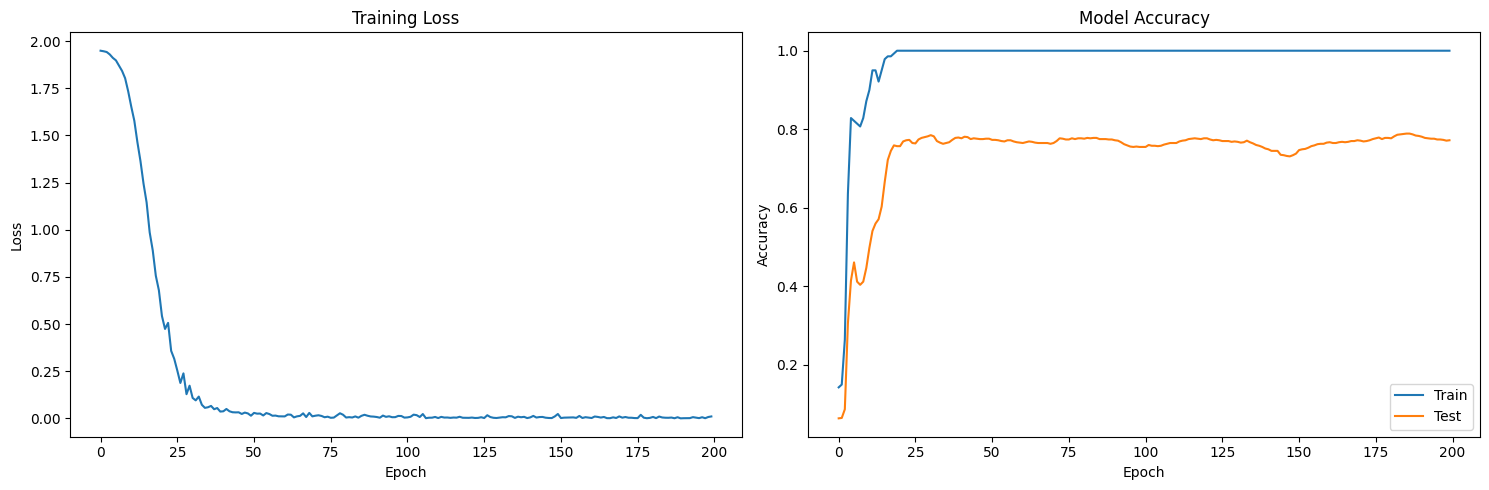

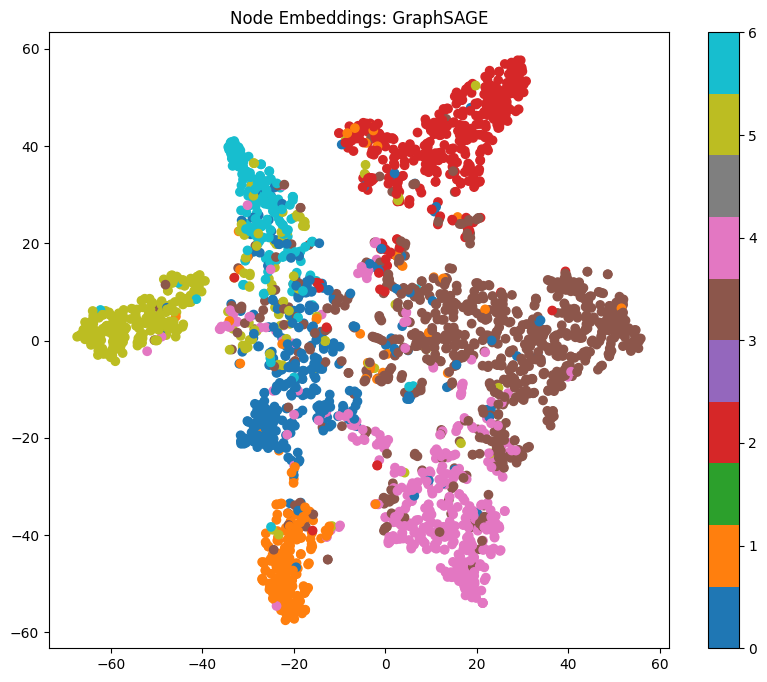

Done for {name}


In [15]:
# GraphSAGE
train_gnn_model("GraphSAGE")

**compare model results**

In [16]:
# comparison
print("\nFinal Results:")
for name, result in results.items():
    print(f"{name}: Best Test Accuracy = {result['best_acc']:.4f}")


Final Results:
GCN: Best Test Accuracy = 0.8140
GAT: Best Test Accuracy = 0.7890
GraphSAGE: Best Test Accuracy = 0.7890
